In [ ]:
%pip install -Uq langgraph langchain langchain-groq langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 19.2 MB/s eta 0:00:00


In [1]:
#%pip install -Uq python-dotenv

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# Set the project name for LangSmith

import os

PROJECT_NAME = "Parallelization"

os.environ["LANGCHAIN_PROJECT"] = PROJECT_NAME

## Introduction

Let's suppose we have a simple example of multiple operations in our graph. But some of those operations can be run concurrently.

In this example, we have a graph with 4 nodes, each node adds a new movie to our state under the property `movies`.

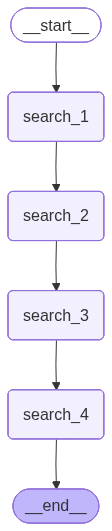

In [3]:
#  a graph with 4 nodes

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

class State(TypedDict):
    movies: list[str] = []

builder = StateGraph(State)

builder.add_node("search_1", lambda x: {"movies": x['movies'] + ["1972 The Godfather"]})
builder.add_node("search_2", lambda x: {"movies": x['movies'] + ["1977 Star Wars: Episode IV"]})
builder.add_node("search_3", lambda x: {"movies": x['movies'] + ["1997 Titanic"]})
builder.add_node("search_4", lambda x: {"movies": x['movies'] + ["2008 The Dark Knight"]})

builder.add_edge(START, "search_1")
builder.add_edge("search_1", "search_2")
builder.add_edge("search_2", "search_3")
builder.add_edge("search_3", "search_4")
builder.add_edge("search_4", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [4]:
graph.invoke({"movies": []})

{'movies': ['1972 The Godfather',
  '1977 Star Wars: Episode IV',
  '1997 Titanic',
  '2008 The Dark Knight']}

## Make two nodes concurrent

To make two nodes run concurrently, just add the edges as necessary to build parallel operations. But note that if we just run the graph like this, we will have problem because we have two nodes trying to update the `movies` property of the state at the same time.

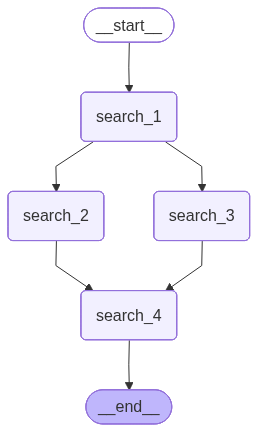

In [5]:
#  a graph with 4 nodes

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

class State(TypedDict):
    movies: list[str] = []

builder = StateGraph(State)

builder.add_node("search_1", lambda x: {"movies": x['movies'] + ["1972 The Godfather"]})
builder.add_node("search_2", lambda x: {"movies": x['movies'] + ["1977 Star Wars: Episode IV"]})
builder.add_node("search_3", lambda x: {"movies": x['movies'] + ["1997 Titanic"]})
builder.add_node("search_4", lambda x: {"movies": x['movies'] + ["2008 The Dark Knight"]})

builder.add_edge(START, "search_1")
builder.add_edge("search_1", "search_2")
builder.add_edge("search_1", "search_3")
builder.add_edge("search_2", "search_4")
builder.add_edge("search_3", "search_4")
builder.add_edge("search_4", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [6]:
# this returns an error

graph.invoke({"movies": []})

InvalidUpdateError: At key 'movies': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE

## Add a reducer

So we add a reducer to manage the sate of the graph even when we have multiple nodes trying to update a single property. This way, every state update goes through the reducer.

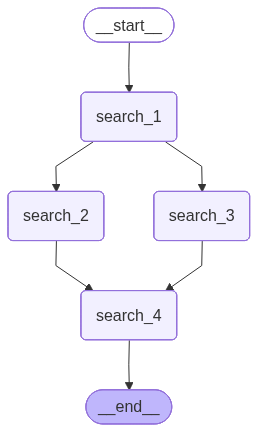

In [12]:
# updating the same state key at the same time is ambiguous

#  a graph with 4 nodes

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict, Annotated
import operator

class State(TypedDict):
    movies: Annotated[list[str], operator.add]

builder = StateGraph(State)

builder.add_node("search_1", lambda x: {"movies": ["1972 The Godfather"]})
builder.add_node("search_2", lambda x: {"movies": ["1977 Star Wars: Episode IV"]})
builder.add_node("search_3", lambda x: {"movies": ["1997 Titanic"]})
builder.add_node("search_4", lambda x: {"movies": ["2008 The Dark Knight"]})

builder.add_edge(START, "search_1")
builder.add_edge("search_1", "search_2")
builder.add_edge("search_1", "search_3")
builder.add_edge("search_2", "search_4")
builder.add_edge("search_3", "search_4")
builder.add_edge("search_4", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [14]:
graph.invoke({"movies": []})

{'movies': ['1972 The Godfather',
  '1977 Star Wars: Episode IV',
  '1997 Titanic',
  '2008 The Dark Knight']}

## Ensure a persistent order in your state

Let's suppose that you want your `movies` key to be ordered alphabetically. But you have parallel nodes working at the same time. How can you make sure that your state is always organized as you intend it to be?

The only thing that we need to do to achieve this is add the sorting to our reducer. In this example, we build our own reducer in order to treat this.

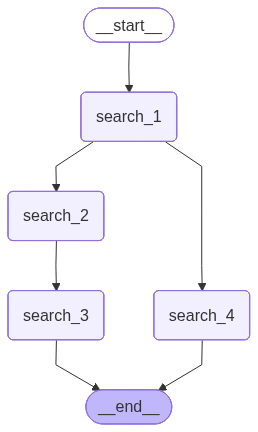

In [15]:
# updating the same state key at the same time is ambiguous

#  a graph with 4 nodes

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict, Annotated
import operator

class State(TypedDict):
    movies: Annotated[list[str], operator.add] = []

builder = StateGraph(State)

builder.add_node("search_1", lambda x: {"movies": ["1972 The Godfather"]})
builder.add_node("search_2", lambda x: {"movies": ["1977 Star Wars: Episode IV"]})
builder.add_node("search_3", lambda x: {"movies": ["1997 Titanic"]})
builder.add_node("search_4", lambda x: {"movies": ["2008 The Dark Knight"]})

builder.add_edge(START, "search_1")
builder.add_edge("search_1", "search_2")
builder.add_edge("search_2", "search_3")
builder.add_edge("search_3", END)
builder.add_edge("search_1", "search_4")
builder.add_edge("search_4", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
# unordered state

graph.invoke({"movies": []})

{'movies': ['1972 The Godfather',
  '1977 Star Wars: Episode IV',
  '2008 The Dark Knight',
  '1997 Titanic']}

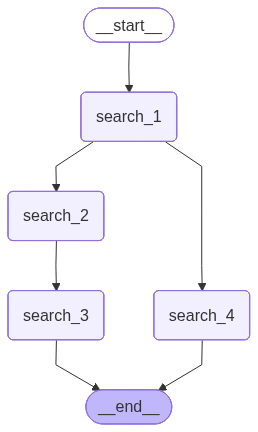

In [17]:
# updateing the same state key at the same time is ambiguous

#  a graph with 4 nodes

from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict, Annotated
import operator

def sorted_reducer(left, right):
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    return sorted(left + right, reverse=False)

class State(TypedDict):
    movies: Annotated[list[str], sorted_reducer] = []

builder = StateGraph(State)

builder.add_node("search_1", lambda x: {"movies": ["1972 The Godfather"]})
builder.add_node("search_2", lambda x: {"movies": ["1977 Star Wars: Episode IV"]})
builder.add_node("search_3", lambda x: {"movies": ["1997 Titanic"]})
builder.add_node("search_4", lambda x: {"movies": ["2008 The Dark Knight"]})

builder.add_edge(START, "search_1")
builder.add_edge("search_1", "search_2")
builder.add_edge("search_2", "search_3")
builder.add_edge("search_3", END)
builder.add_edge("search_1", "search_4")
builder.add_edge("search_4", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
graph.invoke({"movies": []})


{'movies': ['1972 The Godfather',
  '1977 Star Wars: Episode IV',
  '1997 Titanic',
  '2008 The Dark Knight']}